# CSM148 Final Project

*Prithvi Kannan*

*UID: 405110096*


In [1]:
# relevant imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

### Load data

In [2]:
data = pd.read_csv(os.getcwd() + "/healthcare-dataset-stroke-data.csv")

### Basic Statistics

In [3]:
# first 5 rows
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# summary info to understand the different data types in the table
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


* there are only 4909 non-null values for BMI, so we will need to impute missing data
* we will need to encode boolean data such as `gender`, `ever_married`, `residence_type`
* we will need to encode categorical data such as `work_type`, `smoking_status`

In [5]:
# statistics for the numerical features in the table
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


* numerical features are on very difference scales (glucose mean is 106 and BMI mean is 29)

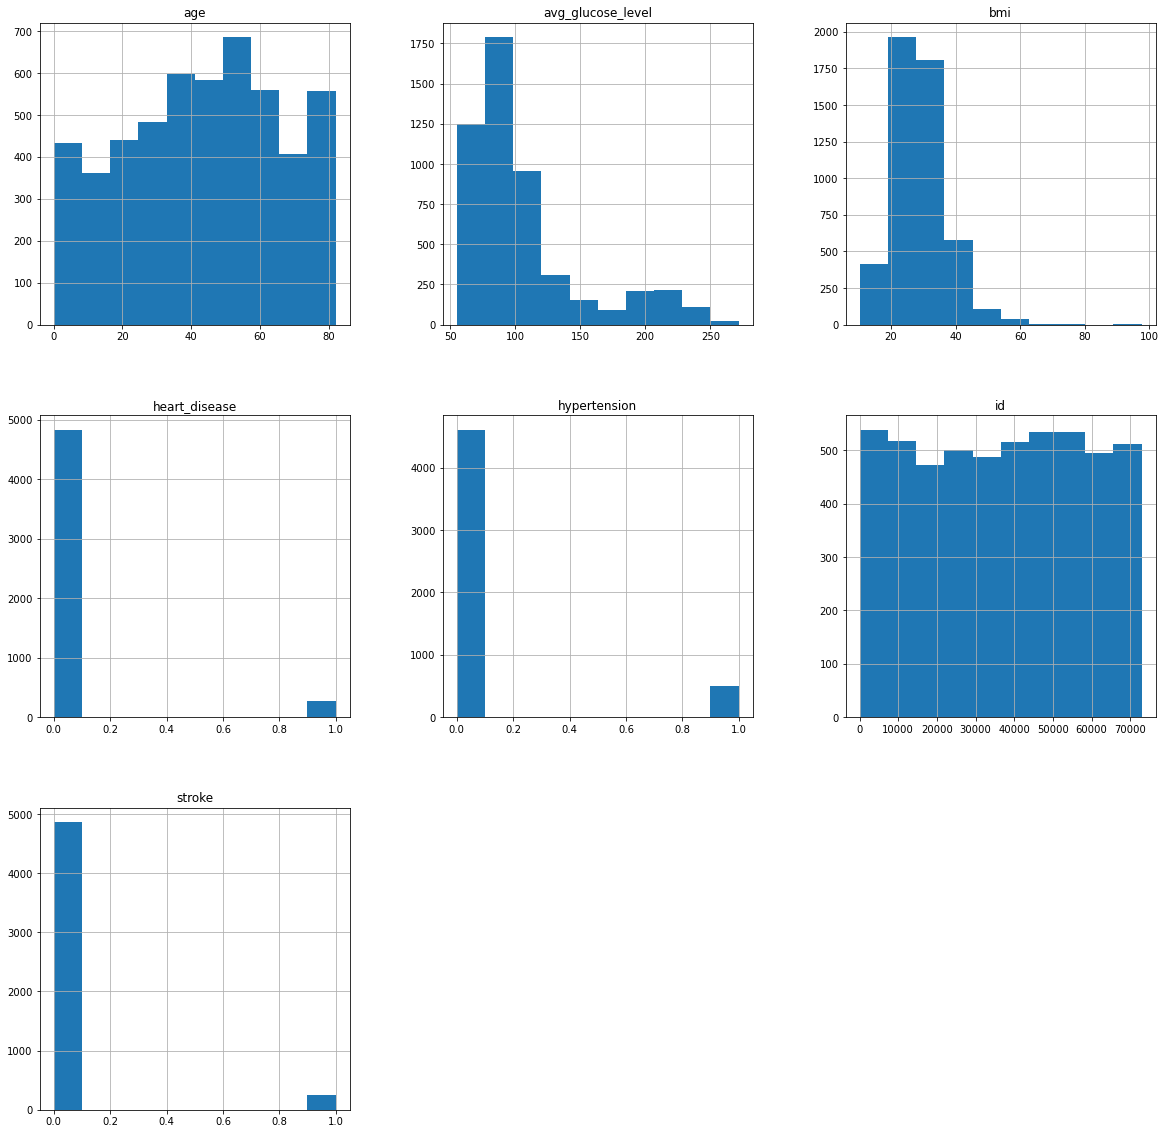

In [6]:
# distributions of different features
data.hist(figsize = (20,20))
plt.show()

* `age` is normally distributed with mean around 43
* `avg_glucose_level` and `bmi` follow a normal curve but are heavily skewed to the right side with many large outliers
* binary features such as `heart_disease` and `hypertension` have significant class imbalance
* target variable `stroke` is imbalanced

In [7]:
data['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

* there is heavy class imbalance amongst 5 different categories

In [8]:
data['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

* "Unknown" category may need to be imputed

In [9]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [10]:
# analyze correlations with inputs and target output stroke
data.corr()['stroke']

id                   0.006388
age                  0.245257
hypertension         0.127904
heart_disease        0.134914
avg_glucose_level    0.131945
bmi                  0.042374
stroke               1.000000
Name: stroke, dtype: float64

### Data Pipeline

In [11]:
# data before pipeline
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [32]:
# run cleanup in pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def run_pipeline(data, should_scale=True, verbose=False):
    processed_data = data

    # drop useless variables
    processed_data.drop(columns=['id'], inplace=True)
    
    # impute bad values
    imputer = SimpleImputer(missing_values="Other", strategy="most_frequent") 
    processed_data['gender'] = imputer.fit_transform(processed_data[['gender']]).ravel()
    imputer = SimpleImputer(missing_values=np.nan, strategy="median") 
    processed_data['bmi'] = imputer.fit_transform(processed_data[['bmi']]).ravel()
    imputer = SimpleImputer(missing_values="Unknown", strategy="most_frequent") 
    processed_data['smoking_status'] = imputer.fit_transform(processed_data[['smoking_status']]).ravel()
    
    # encode binary variables
    binary_replace = {
            "gender": {"Male": 1, "Female": 0},
            "ever_married": {"Yes": 1, "No": 0},
            "Residence_type": {"Rural": 1, "Urban": 0},
        }
    processed_data = processed_data.replace(binary_replace)
    
    # one hot encoding for categorical variables
    categoricals = ['work_type', 'smoking_status']
    one_hot_work = pd.get_dummies(processed_data['work_type'],prefix='work_type',drop_first=True)
    one_hot_smoking = pd.get_dummies(processed_data['smoking_status'],prefix='smoking_status',drop_first=True)
    processed_data = pd.concat([processed_data, one_hot_work, one_hot_smoking], axis=1)
    processed_data.drop(columns=categoricals, inplace=True)

    if verbose:
        print(processed_data.head())
    
    # augment feature
    
    # scale data appropriately
    if should_scale:
        scaler = StandardScaler()
        scaler.fit(processed_data)
        processed_data = scaler.transform(processed_data)    
    
    return processed_data

In [24]:
# train-test split
from sklearn.model_selection import train_test_split

labels = data['stroke']
processed_data = data.drop(columns=['stroke'])
processed_data = run_pipeline(processed_data, should_scale=True)

output = train_test_split(processed_data, labels, test_size = 0.2, stratify=labels)
x_train, x_test, y_train, y_test = output

   gender   age  hypertension  heart_disease  ever_married  Residence_type  \
0       1  67.0             0              1             1               0   
1       0  61.0             0              0             1               1   
2       1  80.0             0              1             1               1   
3       0  49.0             0              0             1               0   
4       0  79.0             1              0             1               1   

   avg_glucose_level   bmi  work_type_Never_worked  work_type_Private  \
0             228.69  36.6                       0                  1   
1             202.21  28.1                       0                  0   
2             105.92  32.5                       0                  1   
3             171.23  34.4                       0                  1   
4             174.12  24.0                       0                  0   

   work_type_Self-employed  work_type_children  smoking_status_never smoked  \
0            

In [25]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4088, 14)
(4088,)
(1022, 14)
(1022,)


### Logistic Regression

In [26]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train, y_train)
print(sum(y_train))
y_predictions = logreg.predict(x_test)
print(sum(y_test))
print(sum(y_predictions))
y_true = list(y_test)


199
50
0


In [27]:
print(f"Accuracy: {str(accuracy_score(y_true, y_predictions))}")
print(f"Precision: {str(precision_score(y_true, y_predictions))}")
print(f"Recall: {str(recall_score(y_true, y_predictions))}")
print(f"F1 Score: {str (f1_score(y_true, y_predictions))}")
print(f"Confusion matrix: {confusion_matrix(y_true, y_predictions)}")


Accuracy: 0.9510763209393346
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion matrix: [[972   0]
 [ 50   0]]
/Users/prithvikannan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### PCA

In [34]:
labels = data['stroke']
processed_data = data.drop(columns=['stroke'])
processed_data = run_pipeline(processed_data, should_scale=False)

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


principalComponents = pca.fit_transform(processed_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, labels], axis = 1)
print(finalDf)



      principal component 1  principal component 2  stroke
0                124.928276              -5.025942       1
1                 97.576400              -2.337664       1
2                  5.547397             -36.529016       1
3                 65.342658               3.892414       1
4                 72.469778             -23.945598       1
...                     ...                    ...     ...
5105             -16.490660             -39.513418       0
5106              24.984721             -35.324289       0
5107             -24.077199               4.251502       0
5108              60.485285               2.131284       0
5109             -20.576350              -3.731341       0

[5110 rows x 3 columns]


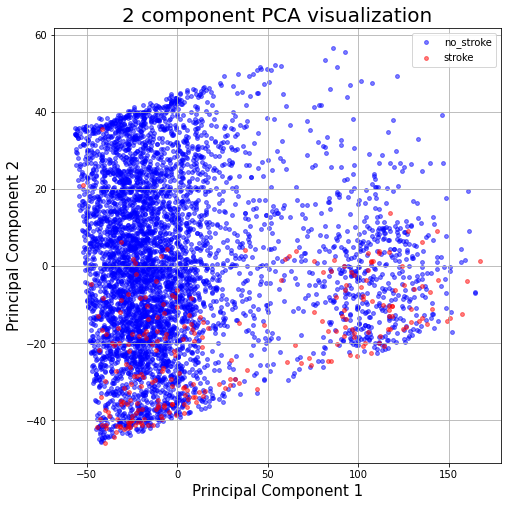

In [47]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA visualization', fontsize = 20)
targets = [0,1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['stroke'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 15, alpha=0.5)
ax.legend(['no_stroke', 'stroke'])
ax.grid()

### Ensemble

In [53]:
# load in data
labels = data['stroke']
processed_data = data.drop(columns=['stroke'])
processed_data = run_pipeline(processed_data, should_scale=True)

output = train_test_split(processed_data, labels, test_size = 0.2, stratify=labels)
x_train, x_test, y_train, y_test = output

In [54]:
# train model and generate predictions
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier(n_estimators=10)
rfr = rfr.fit(x_train, y_train)
y_predictions = rfr.predict(x_test)
y_true = list(y_test)


In [55]:
# interpret results
print(f"Accuracy: {str(accuracy_score(y_true, y_predictions))}")
print(f"Precision: {str(precision_score(y_true, y_predictions))}")
print(f"Recall: {str(recall_score(y_true, y_predictions))}")
print(f"F1 Score: {str (f1_score(y_true, y_predictions))}")
print(f"Confusion matrix: {confusion_matrix(y_true, y_predictions)}")


Accuracy: 0.9452054794520548
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion matrix: [[966   6]
 [ 50   0]]


### Neural Network

In [56]:
# load in data
labels = data['stroke']
processed_data = data.drop(columns=['stroke'])
processed_data = run_pipeline(processed_data, should_scale=True)

output = train_test_split(processed_data, labels, test_size = 0.2, stratify=labels)
x_train, x_test, y_train, y_test = output

In [59]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
mlp = mlp.fit(x_train, y_train)
y_predictions = mlp.predict(x_test)
y_true = list(y_test)

In [60]:
# interpret results
print(f"Accuracy: {str(accuracy_score(y_true, y_predictions))}")
print(f"Precision: {str(precision_score(y_true, y_predictions))}")
print(f"Recall: {str(recall_score(y_true, y_predictions))}")
print(f"F1 Score: {str (f1_score(y_true, y_predictions))}")
print(f"Confusion matrix: {confusion_matrix(y_true, y_predictions)}")


Accuracy: 0.9510763209393346
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion matrix: [[972   0]
 [ 50   0]]
/Users/prithvikannan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross Validation

### Results